# Project 2: Reproducibility in Natural Language Processing



### Read Data

In [3]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-dark') 

In [4]:
# read in SOTU.csv using pandas, name the variable `sou` for simplicity
# the below cell is what the output should look like
sou = pd.read_csv("data/SOTU.csv")
sou

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169
...,...,...,...,...
241,George Washington,1791.0,\nFellow-Citizens of the Senate and House of R...,2264
242,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
243,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
244,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069


In [20]:
print(sou['Year'].unique().min())
sou['Year'].unique().max()

1790


np.int64(2024)

## Part 2: Simple Text Processing - Tokenization, Lemmatization, Word Frequency, Vectorization (20 pts)

Now we will start working on simple text processing using the `SpaCy` package and the same dataset as Part 1. The package should already be included in the `environment.yml`. However, we will also need to download `en_core_web_sm`, an English language text processing model. To do this, while having your `sotu` environment activated, run the following:

```
python -m spacy download en_core_web_sm
```

Now, you should be good to go!

Some important definitions:

- *Token*: a single word or piece of a word
- *Lemma*: the core component of a word, e.g., "complete" is the lemma for "completed" and "completely"
- *Stop Word*: a common word that does not add semantic value, such as "a", "and", "the", etc.
- *Vectorization*: representing a document as a vector where each index in the vector corresponds to a token or word and each entry is the count.

In this section, we will explore the most common tokens and lemmas throughout different slices of the speech data. We will also develop vectorization representations of the speeches. 

 The core steps are:

1. Process speeches using the SpaCy nlp module
2. Analyze Tokens vs Lemmas:
- Create a list of all tokens across all speeches that are not stop words, punctuation, or spaces.
- Create a second list of the lemmas for these same tokens.
- Display the top 25 for each of these and compare.
3. Analyze common word distributions over different years:
- Create a function that takes the dataset and a year as an input and outputs the top n lemmas for that year's speeches
- Compare the top 10 words for 2023 versus 2019
4. Document Vectorization:
- Train a Term Frequency-Inverse Document Frequency (TF-IDF) vectorization model using your processed dataset and scikit learn
- Output the feature vectors 

**Helpful Resources:**
- https://realpython.com/natural-language-processing-spacy-python/
- https://www.statology.org/text-preprocessing-feature-engineering-spacy/ 
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html# 
- https://www.geeksforgeeks.org/nlp/how-to-store-a-tfidfvectorizer-for-future-use-in-scikit-learn/ 



### Processing Speeches with SpaCy

Lets study just speeches from 2000 and onwards to begin with. So, be sure to subset your DataFrame to just these speeches before continuing!

In [5]:
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

In [6]:
# subset the speech dataframe for speeches from 2000 and onwards
sou["Year"] = sou["Year"].astype(int)
sou_2000 = sou[sou["Year"] >= 2000]
sou_2000["Year"].unique()

array([2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014,
       2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003,
       2002, 2001, 2000])

In [7]:
# Process each speeches using the 'nlp' function
# Hint - loop through each speech and pass the text into the nlp function above, storing the output in a list
# should take about 30 seconds to process

processed_docs = []  # store processed spaCy docs

for text in tqdm(sou["Text"], desc="Processing speeches"):
    doc = nlp(text)
    processed_docs.append(doc)

Processing speeches: 100%|██████████| 246/246 [04:56<00:00,  1.20s/it]


### Analyze Tokens vs Lemmas

#### Token List

Create a list of tokens across all speeches that are not spaces, stopwords, or punctuation. Make each token lowercase as well. *Hint: each element of the list we just created are themselves lists of tokens. Token objects have attributes `is_stop`, `is_punct`, and `is_space`.*

In [8]:
clean_tokens = []

for doc in processed_docs:
    tokens = [
        token.text.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    clean_tokens.append(tokens)

In [9]:
from collections import Counter

# Flatten the list of lists into one list of tokens (if you haven't already)
all_tokens_flat = [tok for speech in clean_tokens for tok in speech]

# Count token frequency
token_counts = Counter(all_tokens_flat)

# Print top 20 most common tokens
top_20 = token_counts.most_common(20)
top_20

[('government', 7462),
 ('states', 6837),
 ('congress', 5403),
 ('united', 5113),
 ('people', 4458),
 ('year', 4394),
 ('$', 4074),
 ('country', 3724),
 ('great', 3479),
 ('public', 3356),
 ('new', 3228),
 ('time', 3128),
 ('american', 3009),
 ('war', 2877),
 ('world', 2771),
 ('years', 2614),
 ('law', 2311),
 ('nation', 2300),
 ('national', 2291),
 ('state', 2253)]

#### Lemma List

Do the same as above, but for lemmas. *Hint: recall lemmas are components of words. Each token should have an attribute to extract the lemma.*

In [10]:
# Create list of lemma tokens (not stopwords, not punctuation)
lemma_tokens = []

for doc in processed_docs:
    lemmas = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space and not token.like_num
    ]
    lemma_tokens.append(lemmas)

from collections import Counter

# Flatten list of lists
all_lemmas_flat = [lemma for speech in lemma_tokens for lemma in speech]

# Count frequency
lemma_counts = Counter(all_lemmas_flat)

# Top 20 lemmas
top_20_lemmas = lemma_counts.most_common(20)
top_20_lemmas


[('government', 8293),
 ('year', 7008),
 ('states', 6517),
 ('congress', 5408),
 ('united', 5050),
 ('country', 4790),
 ('people', 4651),
 ('great', 4447),
 ('$', 4074),
 ('nation', 3985),
 ('law', 3737),
 ('time', 3603),
 ('public', 3356),
 ('new', 3240),
 ('war', 3037),
 ('american', 3022),
 ('power', 2977),
 ('work', 2919),
 ('world', 2772),
 ('state', 2770)]

#### Token versus Lemma Comparison

What do you notice about the top tokens versus the top lemmas? 
Consider two tokens - "year" and "years" - how do their counts compare to the lemma "year"?
What about the lemma "child"?

### Common Words

#### Common Words per Year Function

Fill in the below function to obtain the n-most common words in speeches for a given year.

inputs: 
- df raw unprocessed sou dataframe
- year
- n
outputs: 
- top n words for that years

steps:
- subset the dataframe for the year of interest - note the years might not be in int type
- process the subsetted dataframe with spacy
- get the lemmas across all those speeches
- count the top n lemmas

In [11]:
def get_most_common_words(df, year, n=25):
    """
    Processes the SOTU speech for a given year and returns
    the most common non-stopword/punctuation lemmas.
    """

    # Step 1: Subset df
    df_year = df[df["Year"].astype(str) == str(year)]
    if df_year.empty:
        return []
    lemmas = []

    for text in df_year["Text"]:
        doc = nlp(text)
        # Step 3: Get clean lemmas (lowercase, no stopwords/punct/space/numbers)
        lemmas.extend(
            token.lemma_.lower()
            for token in doc
            if not token.is_stop
            and not token.is_punct
            and not token.is_space
            and not token.like_num
        )

    lemma_counts = Counter(lemmas)
    return lemma_counts.most_common(n)

In [12]:
# test it on 2024
get_most_common_words(sou, 2024, n=10)

[('president', 58),
 ('year', 45),
 ('america', 44),
 ('american', 34),
 ('people', 33),
 ('$', 33),
 ('member', 32),
 ('want', 29),
 ('audience', 29),
 ('know', 29)]

In [43]:
# Hint - put the words and counts into a pd Dataframe for better structure
# and to make plotting easier
df_2017 = ...
df_2023 = ...

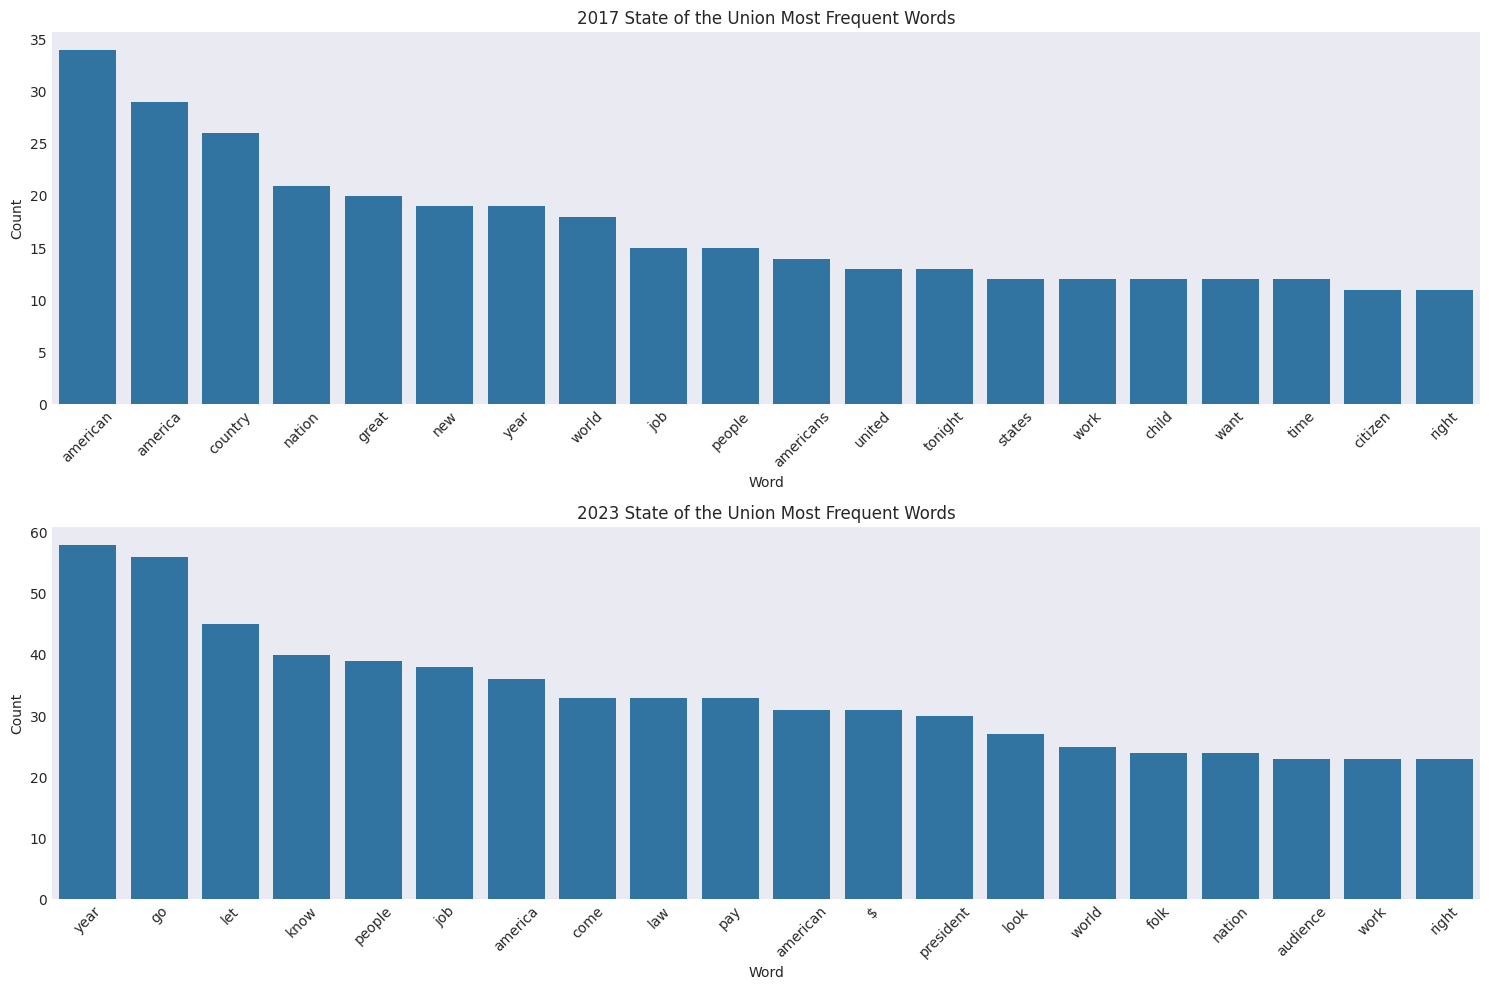

In [44]:
# Hint - use seaborn, subplots, and rotate tick labels

### TF-IDF Vectorization

To use statsitical alorithms on documents, we need to transform them into vectors, where each element of the vector corresponds to a particular word in a document or corpus of documents. One common way is via TF-IDF embeddings. LLMs work similarly - they typically use transformer models to generate text embeddings before sending text through a deep neural network. 

Here we will fit a TF-IDF vectorizer, plot all the speeches on a 2-D grid using PCA and also using a heatmap, and examine TF-IDF scores for the top 10 most common words in the first speech. This is a good resource here: https://medium.com/GeoffreyGordonAshbrook/vector-visualization-2d-plot-your-tf-idf-with-pca-83fa9fccb1d 

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

#### Train the Vectorizer and Transform the Data

In [50]:
# you may use this as input to fit the TF-IDF vectorizer
raw_docs = sou["Text"].to_list()

In [51]:
# Hint - use fit_transform for vectorizer and PCA

The output of `fit_transform()` will be a matrix where each row corresponds to a speech, each column corresponds to a word in the corpus of speeches, and the value is the TF-IDF score which measures the importance of that word in that speech, relative to the rest of the speeches.

#### Plot Speeches

- First used PCA to generate the first chart
- Second use seaborn heatmap with a log-scaled color axis to generate the second chart

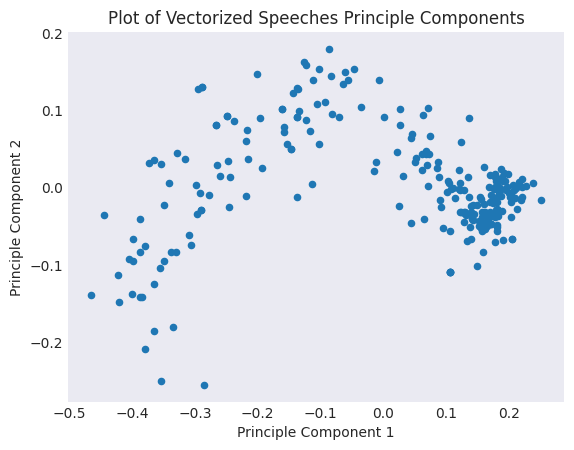

In [52]:
# Step 1: Set PCA to find first 2 principal components

# Step 2: Create a new dataframe where each row is a speech, and each column is a projection onto
# one of the two principal components

# Plot Data Visualization (Matplotlib)

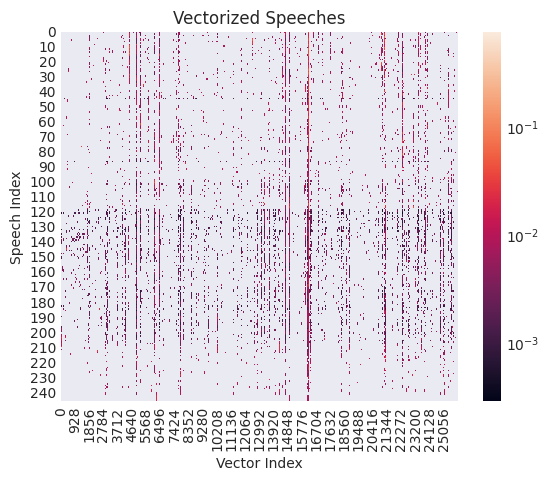

In [53]:
# Hint - vectorized_docs is a sparse matrix whose rows are speeches and columns are tokens, with each
# value being a TF-IDF score. Densify this array first, and then plot using seaborn.

#### Get the TF-IDF value for certain words and documents

In [64]:
word_list = ['year',
 'america',
 'people',
 'american',
 'work',
 'new',
 'job',
 'country',
 'americans',
 'world'] # top ten most common words through whole corpus

In [65]:
word_nums = ... # get each word's index number using the .vocabular_ attributed of vectorizer

In [66]:
idf_score = ... # get their IDF score by using .idf_ at the indices from the previous step

In [67]:
tf_idf = ... # get the tf_idf score for the first speech

In [68]:
pd.DataFrame({"Word": word_list, "IDF Score": idf_score, "TF-IDF Score": tf_idf})

,Word,IDF Score,TF-IDF Score
0,year,1.032925,0.022719
1,america,1.272946,0.068439
2,people,1.037118,0.043087
3,american,1.102217,0.045792
4,work,1.162281,0.005681
5,new,1.024591,0.016275
6,job,2.043480,0.009988
7,country,1.008130,0.013550
8,americans,1.713598,0.041877
9,world,1.138750,0.026438


## Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling (20 pts)

**Resources:**
- LDA:
    - https://medium.com/sayahfares19/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06 
    - https://www.kaggle.com/code/faressayah/text-analysis-topic-modeling-with-spacy-gensim#%F0%9F%93%9A-Topic-Modeling (code for previous post)
    - https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf/ 
- BERTopic:
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_documents.html#visualize-documents-with-plotly 
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_topics.html 


In [72]:
from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models

### LDA

- Train an LDA model with 18 topics
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization

You may use the next two cells to process the data.

In [73]:
def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

In [74]:
# Process all texts - note this takes ~ 5 minutes to run
processed_docs = sou['Text'].apply(preprocess_text)

To train an LDA model, use the LdaModel function that we imported a couple of cells back. The last resource linked under the LDA section is especially useful for walking through the steps we have below. *Note: one of the arguments to the LdaModel function is `random_state` which specifies the random seed for reproducibility. Please set yours to 42. Further, the last resource provided uses `LdaMulticore` which is essentially a parallelizable version of our function `LdaModel`. Use `LdaModel` instead, but the usage will be similar, except you can ignore the `iterations` and `workers` arguments..*.

In [77]:
# Build dictionary from processed_docs, which is a list of tokens extracted from our speeches

In [78]:
# train LDA model with 18 topics

In [79]:
# print the top 10 words for each topic


--- LDA Topics ---
Topic: 0 
Words: 0.004*"cent" + 0.004*"june" + 0.004*"gold" + 0.003*"island" + 0.003*"silver" + 0.003*"bond" + 0.003*"method" + 0.003*"convention" + 0.003*"indian" + 0.003*"note"

Topic: 1 
Words: 0.008*"depression" + 0.007*"program" + 0.007*"recovery" + 0.006*"budget" + 0.006*"unemployment" + 0.006*"loan" + 0.006*"activity" + 0.006*"farm" + 0.005*"emergency" + 0.005*"cent"

Topic: 2 
Words: 0.008*"dictator" + 0.005*"expression" + 0.004*"british" + 0.004*"1914" + 0.003*"impressive" + 0.003*"actual" + 0.003*"revolution" + 0.003*"schedule" + 0.003*"continent" + 0.003*"partisanship"

Topic: 3 
Words: 0.008*"forest" + 0.007*"corporation" + 0.005*"judge" + 0.005*"wrong" + 0.005*"interstate" + 0.004*"employee" + 0.003*"bureau" + 0.003*"body" + 0.003*"mountain" + 0.003*"island"

Topic: 4 
Words: 0.017*"program" + 0.014*"soviet" + 0.009*"1980" + 0.009*"u.s." + 0.008*"area" + 0.007*"major" + 0.006*"goal" + 0.006*"commitment" + 0.006*"challenge" + 0.006*"nuclear"

Topic: 5 
W

In [83]:
# print the topic distribution for the first speech

[(11, np.float32(0.99942815))]


In [ ]:
# make a visualization using pyLDAvis
pyLDAvis.enable_notebook()
...

### BERTopic

- Train a BERTopic model with a `min_topic_size` of 3 *Hint: use `BERTopic` to instantiate the model and specify `min_topic_size` in here. Actually fit the model using `fit_transform`, which `docs` passed into this.*
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization of the topics (see topic_model.visualize_topics())

In [85]:
docs = sou['Text'].to_list()

In [86]:
# train the model - this takes about 30 seconds

# remove stop words from the topics (Hint: use CountVectorizer and then .update_topics on topic_model)

2025-11-08 22:50:56,658 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
2025-11-08 22:51:09,053 - BERTopic - Embedding - Completed ✓
2025-11-08 22:51:09,054 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-08 22:51:19,326 - BERTopic - Dimensionality - Completed ✓
2025-11-08 22:51:19,327 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-08 22:51:19,342 - BERTopic - Cluster - Completed ✓
2025-11-08 22:51:19,346 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-08 22:51:20,853 - BERTopic - Representation - Completed ✓


In [87]:
# output the top 10 words for each topic - hint see get_topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,56,-1_states_government_united_congress,"[states, government, united, congress, country...",[\nTo the Congress of the United States:\nYour...
1,0,29,0_world_people_new_years,"[world, people, new, years, america, american,...","[\nMr. Speaker, Mr. President, my colleagues i..."
2,1,18,1_america_americans_american_people,"[america, americans, american, people, tonight...","[\nMr. Speaker, Vice President Cheney, Members..."
3,2,17,2_states_government_united_congress,"[states, government, united, congress, public,...",[\nTo the Senate and House of Representatives ...
4,3,15,3_states_government_united_law,"[states, government, united, law, congress, ye...",[\nTo the Senate and House of Representatives:...
5,4,12,4_government_work_public_congress,"[government, work, public, congress, great, la...",[\nTo the Senate and House of Representatives:...
6,5,11,5_world_peace_nations_soviet,"[world, peace, nations, soviet, nation, econom...","[\nMr. President, Mr. Speaker, Members of the ..."
7,6,9,6_british_states_united_war,"[british, states, united, war, enemy, great, f...",[\nFellow-Citizens of the Senate and House of ...
8,7,8,7_states_government_congress_united,"[states, government, congress, united, year, c...",[\nFellow-Citizens of the Senate and House of ...
9,8,8,8_america_americans_jobs_new,"[america, americans, jobs, new, american, that...","[\nMadam Speaker, Mr. Vice President, Members ..."


100%|██████████| 1/1 [00:14<00:00, 14.91s/it]


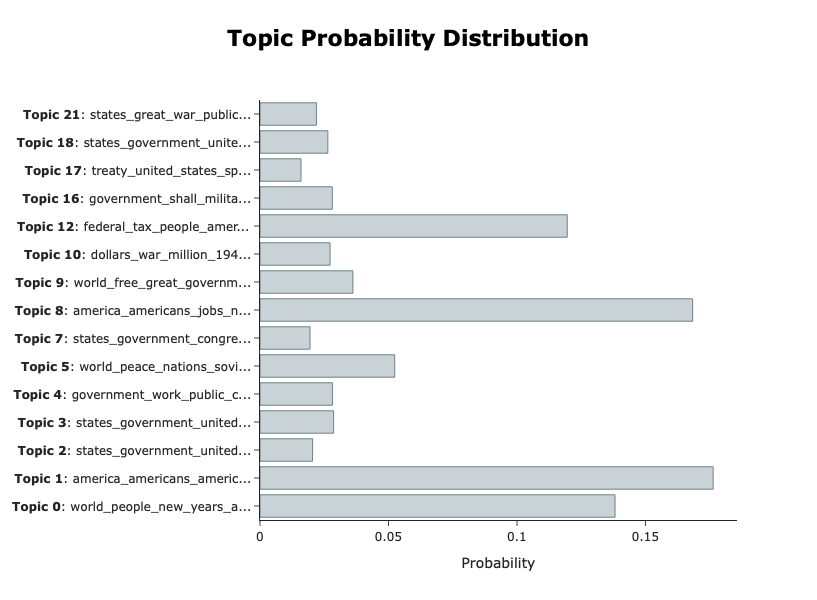

In [88]:
# output the topic distribution for the first speech
# hint: check out approximate_distribution() and visualize_distribution()

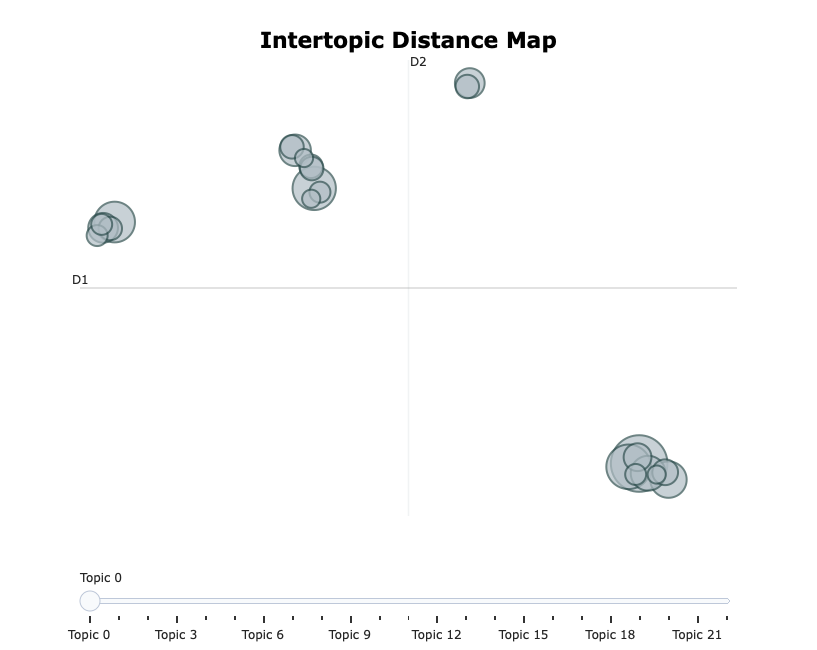

In [90]:
# run this cell to visualize the topics
topic_model.visualize_topics()

## Part 4: Choose your own advecnture! (7 Points; Optional for Extra Credit)

This section is open ended and your chance to explare any advanced analysis. Please perform any additional analysis you find interesting! Suggested analyses (only do one max):

- Topic evolution over time - see https://maartengr.github.io/BERTopic/getting_started/topicsovertime/topicsovertime.html#visualization 
- Word frequency over time - does the frequency of certain words change over time
- Semantic similarity - investigate similarity within and between presidents or time periods. For example, similarity between one presidents speeches, e.g. are all of Biden's speeches similar to each other? How similar are they to Trump's speeches? Are speeches from the 2000s more similar to each other than speeches in the 1800s? Which two presidents have the most similar speeches? See https://spacy.io/usage/linguistic-features#vectors-similarity 
-  Named Entity Recognition - which entity types are most common in speeches? What are the most common words for each entity type - see https://spacy.io/usage/linguistic-features#named-entities 
- Classification - can you build a classifier to detect democratic versus republican state of the union speeches from 1980-2024 - see https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py 


## Choosing word frequency over time

In Part 4, we will see the frequency change of certain words over time. 

I have chosen words that were significant in specific time points as well as among from the Top 20 words in Part 2. 

In [21]:
#Filtering out modern speeches (from 1900-2024)
#This gives us a smaller and more consistent dataset → better NLP
sou_modern = sou[sou["Year"].astype(int) >= 1900].copy()
sou_modern.reset_index(drop=True, inplace=True)

sou_modern.head()

,President,Year,Text,Word Count
0,Joseph R. Biden,2024,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020,\nThe President. Thank you very much. Thank yo...,6169


### 1. Filter modern speeches
First, we filtered out modern speeches, specifically from 1900 to 2024, since it would give us a smaller and more consistent dataset. 

### 2. Add token counts for normalization
Next, we will add token counts for normalization. We will reconstruct a processed_modern just like we did in part 2 where we processed processed_docs. This helps us convert raw counts into frequency per 1,000 words so that speeches with more text don’t incorrectly “win”.

In [23]:
# Reprocess with spaCy to match filtered rows
processed_modern = [nlp(text) for text in tqdm(sou_modern["Text"], desc="Processing modern speeches")]

# Count tokens
sou_modern["TokenCount"] = [len(doc) for doc in processed_modern]

Processing modern speeches: 100%|██████████| 131/131 [02:30<00:00,  1.15s/it]


In [24]:
sou_modern["Year"].min(), sou_modern["Year"].max(), len(sou_modern)

(np.int64(1900), np.int64(2024), 131)

We check whether the sou_modern includes the right range of years. It seems yes. 

### 3. Function: Count a target lemma in a single doc
Next, we will convert the target word into a lowercase lemma form (for consistency) and count how many tokens in the doc match that lemma. 

In [25]:
def count_lemma_in_doc(doc, target_word):
    target = target_word.lower()
    return sum(
        1
        for token in doc
        if token.lemma_.lower() == target
        and not token.is_stop
        and not token.is_punct
        and not token.is_space
        and not token.like_num
    )

In [26]:
#example test run of Function
test_count = count_lemma_in_doc(processed_modern[0], "economy")
test_count

7

Here, we can see that the result of the function is an integer (could be 0–30 depending on the speech).

### 4. Count word frequency per speech and normalize
To compare keyword usage fairly across speeches of very different lengths, we calculate normalized word frequency:

How many times does the word appear per 1,000 tokens in the speech?

This prevents longer speeches from automatically having higher counts.
We do this by:
- Looping over each processed speech
- Counting the number of times the target lemma appears
- Dividing by the total number of tokens in the speech
- Multiplying by 1,000 to obtain frequency per 1,000 words
- Returning a list aligned with the filtered dataset (sou_modern)
This normalized metric allows meaningful trend analysis of how political topics rise and fall over time.

In [27]:
def get_word_frequency_over_time(processed_docs, df, target_word):
    freqs = []

    for doc, tok_count in zip(processed_docs, df["TokenCount"]):
        count = count_lemma_in_doc(doc, target_word)
        freq_per_1000 = (count / tok_count) * 1000  # normalize
        freqs.append(freq_per_1000)

    return freqs


In [28]:
#testing one word: Economy
sou_modern["economy_freq"] = get_word_frequency_over_time(
    processed_modern, sou_modern, "economy"
)

sou_modern[["Year", "economy_freq"]].head()

,Year,economy_freq
0,2024,0.667875
1,2023,0.513919
2,2022,1.376098
3,2021,0.823808
4,2020,0.665513


We can see that the frequency of the word 'economy' is printed out successfully using the function made above. 

Now we will repeat the same process for the five chosen words, which are:

1. inflation
2. health
3. China
4. terror
5. immigration

In [30]:
# Apply to selected keywords
keywords = ["inflation", "health", "china", "terror", "immigration"]
for word in keywords:
    sou_modern[f"{word}_freq"] = get_word_frequency_over_time(processed_modern, sou_modern, word)


### 5. Plotting frequency change for each of the five words
Lastly, we will plot the normalized frequency trends over time.

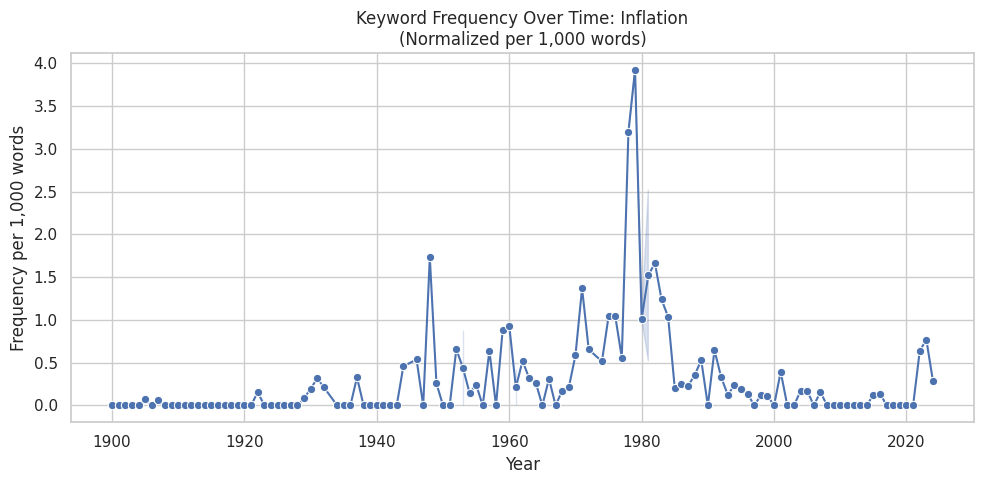

Saved plot: outputs/inflation_frequency_plot.png


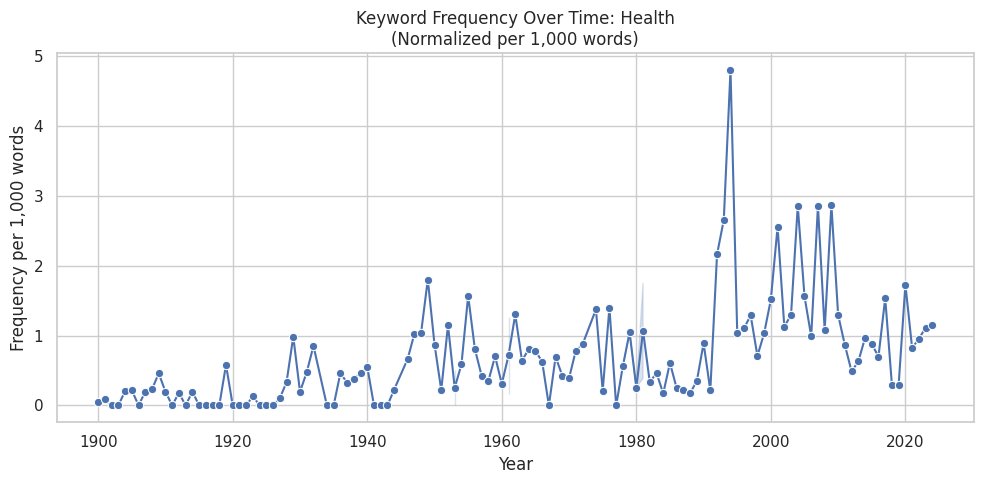

Saved plot: outputs/health_frequency_plot.png


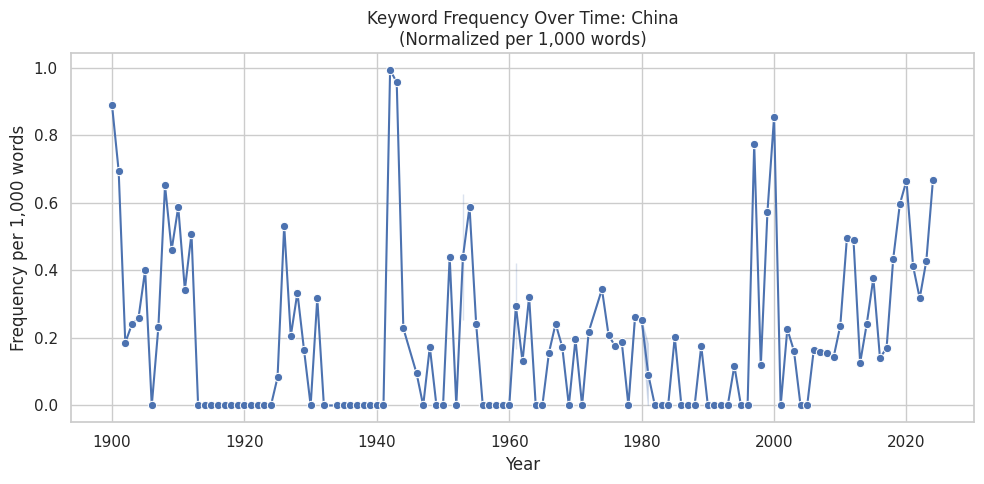

Saved plot: outputs/china_frequency_plot.png


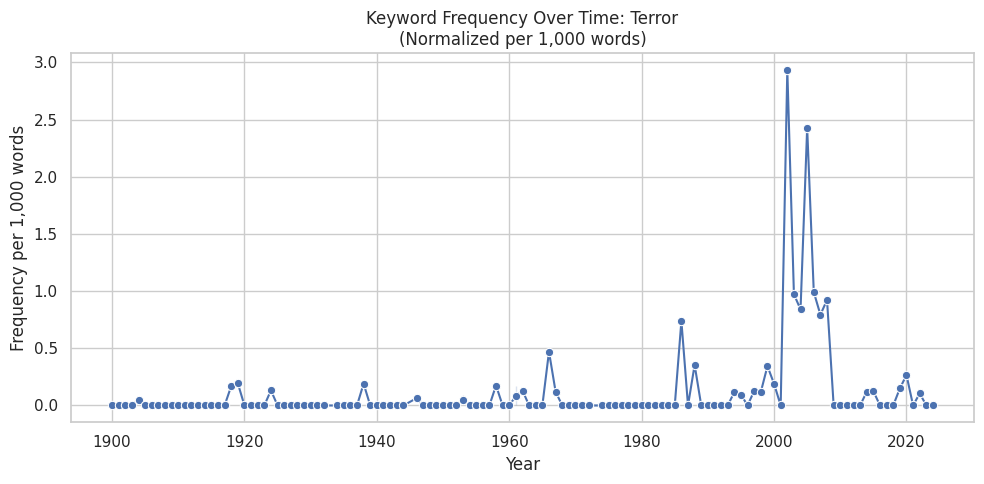

Saved plot: outputs/terror_frequency_plot.png


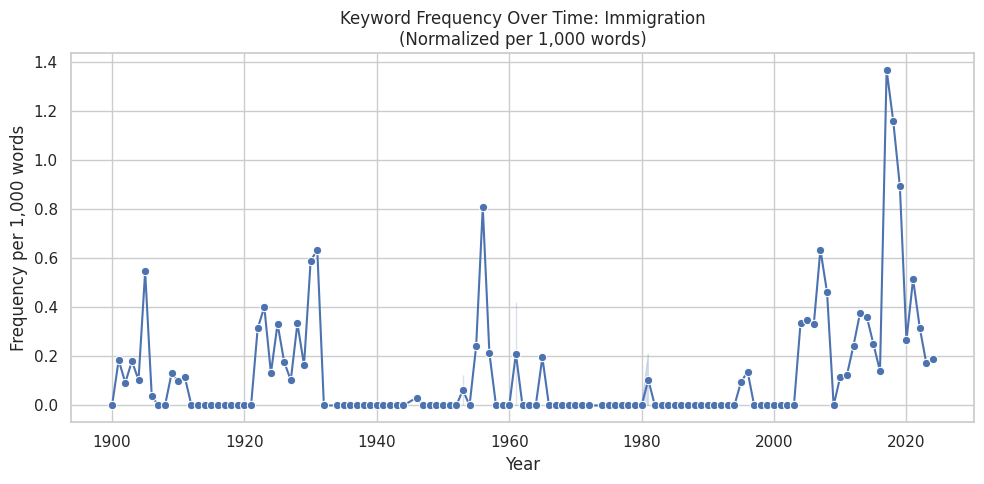

Saved plot: outputs/immigration_frequency_plot.png


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")

def plot_each_word(df, words, save_dir="outputs"):
    
    # Ensure the directory exists (won't overwrite)
    os.makedirs(save_dir, exist_ok=True)
    
    for word in words:
        plt.figure(figsize=(10, 5))
        sns.lineplot(
            data=df,
            x="Year",
            y=f"{word}_freq",
            marker="o"
        )
        
        plt.title(f"Keyword Frequency Over Time: {word.capitalize()}\n(Normalized per 1,000 words)")
        plt.xlabel("Year")
        plt.ylabel("Frequency per 1,000 words")
        plt.tight_layout()
        
        # Save plot to outputs folder
        filename = f"{save_dir}/{word}_frequency_plot.png"
        plt.savefig(filename, dpi=300)
        
        plt.show()
        print(f"Saved plot: {filename}")

# Run it!
keywords = ["inflation", "health", "china", "terror", "immigration"]
plot_each_word(sou_modern, keywords)


### 6. Interpretation of the plots

## 📊 **Results: Keyword Frequency Trends in SOTU Speeches (1900–2024)**

### 🔹 Inflation
Over most of the 20th century, mentions of *inflation* are relatively rare, reflecting a historically stable price environment. Usage spikes sharply in the late 1970s and early 1980s, aligning with high U.S. inflation during the oil crisis and stagflation era. A smaller spike appears around 2022, consistent with the recent rise in inflation following the COVID-19 pandemic. These peaks closely track well-known periods of economic strain.

---

### 🔹 Health
References to *health* rise steadily starting mid-20th century as public health and healthcare infrastructure become national priorities. A major peak appears in the 1990s, followed by consistently heightened use in the 2000s and 2010s. This aligns with political focus on Medicare/Medicaid expansion, the Affordable Care Act, and aging population concerns. Health is clearly a growing long-term policy topic.

---

### 🔹 China
Discussion of *China* is minimal before the 1970s, consistent with limited diplomatic or economic engagement. Mentions rise significantly after the late 1990s, aligning with China’s rapid economic growth and increasing geopolitical importance. The upward trend continues into the 21st century, reflecting trade tensions, global supply chains, and national security concerns.

---

### 🔹 Terror
Mentions of *terror* remain nearly nonexistent before 2001. Following the 9/11 attacks, there is an immediate and dramatic spike, reflecting the central role of counter-terrorism in U.S. policy during the Bush administration. Frequency declines after the early 2010s as focus shifts toward other domestic and international priorities.

---

### 🔹 Immigration
References to *immigration* fluctuate modestly throughout the 20th century, with periodic peaks during policy reforms. A sustained rise emerges after ~2005, reflecting increasing political polarization around immigration, border security, and population shifts. The sharp increase in the late 2010s aligns with heightened debate during the Trump administration.
